# Librairies

In [2]:
import glob
from pathlib import Path
import os
import sys
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.regularizers import l1 
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(1)


/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
rootDir='/home/charles/Projects/NeuralNetPopulation'
sys.path.append("/home/charles/Projects/NeuralNetPopulation/Python")

from dataGeneration.dataGeneratorFactory import DataGeneratorFactory
from dataGeneration.rawDataInput import RawDataInput

from models.convNetParams import ConvNetParams
from models.mdlFit import MdlFit
from models.mdlEval import MdlEval
from models.mdlLayerInspection import MdlLayerInspection

from utils.pathBuilder import PathBuilder

In [18]:
16*16

256

# Parameters

In [4]:
provider = 'Mapbox'
gridSize = 100
resp="v_CA16_406"
penultimateNonLin ='elu'
finalNonLin='linear'
optimizerClass = Adam
lrInit=10**-2
numEpochs=100
finalFcUnits = 2**4 #try something smaller than the initial 16 to reduce the computational burden
lossFct='mean_squared_error' # mean_absolute_error
 

In [5]:
ubNumImages=50

In [29]:
v=VGG19(include_top=False, 
                               weights='imagenet',
                               classes=1,
                               input_shape= newDim )
#v.summary()
(3*27 + 3) * 3

252

# Pre - filter model

In [6]:
repDim=(480,480,3)

In [7]:
filterSize=3
poolSize=3
numFilters=3

In [8]:
d=math.ceil((repDim[0]-filterSize-poolSize)/2)

In [30]:
(480-6)/2

237.0

In [9]:
newDim = (d , d, numFilters)
newDim

(237, 237, 3)

In [10]:

with warnings.catch_warnings () :
    convNetExtractorSmaller = VGG19(include_top=False, 
                               weights='imagenet',
                               classes=1,
                               input_shape= newDim )
    
    convNetExtractorInit = VGG19(include_top=False, 
                               weights='imagenet',
                               classes=1,
                               input_shape= repDim )
    


In [11]:
inputTensorFeatExtractor = convNetExtractorInit.layers[0].input

convOutput1=Conv2D(filters=numFilters,kernel_size=filterSize,activation='relu')(inputTensorFeatExtractor)
convOutput2=Conv2D(filters=numFilters,kernel_size=filterSize,activation='relu')(convOutput1)
poolOutput=MaxPooling2D(pool_size=3, strides=2) (convOutput2)

In [12]:
inp = poolOutput
for l in convNetExtractorSmaller.layers[1:]:
    l.trainable=False
    out=l(inp)
    inp=out

In [13]:
        #Flatten them + use these for prediction
        flatLyr = Flatten(name='flatten')(inp)

        penultimateDenseLyr = Dense(units=16, #usually 2**4
                              activation='relu',
                              kernel_initializer='he_uniform',
                              name='fc1'  )(flatLyr)

        #Just one fully connected layers 
        #Try with L1 norm one and/or drop out if evidence of overfiting an poor generalsation power 
        finalDenseLyr = Dense(units=16 , #usually 2**4
                              activation='relu',
                              kernel_initializer='he_uniform',
                              name='fc2' , 
                               )(penultimateDenseLyr)
        

 
     
        finalOutput = Dense(1,
                            name='predictions',
                            activation='linear',
                            kernel_initializer='he_uniform' )(finalDenseLyr)

 

In [14]:
mdlFinal = Model(inputTensorFeatExtractor, finalOutput)

optInst=Adam(lr=10**-2)
mdlFinal.compile(loss='mean_squared_error' , optimizer=optInst)

#Both are models
type(mdlFinal), type(convNetExtractorSmaller)

mdlFinal.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 480, 480, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 478, 478, 3)       84        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 476, 476, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 237, 237, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 237, 237, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 237, 237, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 118, 118, 64)      0     

(tensorflow.python.keras.engine.training.Model,
 tensorflow.python.keras.engine.training.Model)

# Models - over and under parameterized

In [14]:
        #Instantiate the conv net (vgg, resnet, etc.)
        with warnings.catch_warnings () :
            convNetExtractor = VGG19(include_top=False, 
                                       weights='imagenet',
                                       input_shape= (480,480,3) )
 
            
        
        #Fix the base layers-> use for feature extraction
        numLayers=len(convNetExtractor.layers)
        for k, layer in enumerate(convNetExtractor.layers):
            layer.trainable = False

        # Conv net/feature extractor output- check out the artRecognition.mdlFit.mdlFinal.py for an alternative less verbose tehnique
        inputTensorFeatExtractor = convNetExtractor.layers[0].input
        outputTensorFeatExtractor = convNetExtractor.layers[len(convNetExtractor.layers)-1].output
        mdlFeatExtractor = Model(inputTensorFeatExtractor, outputTensorFeatExtractor)
        outputMdlInit=mdlFeatExtractor(inputTensorFeatExtractor)

        #Flatten them + use these for prediction
        flatLyr = Flatten(name='flatten')(outputMdlInit)

        penultimateDenseLyr = Dense(units=16, #usually 2**4
                              activation='relu',
                              kernel_initializer='he_uniform',
                              name='fc1'  )(flatLyr)

        #Just one fully connected layers 
        #Try with L1 norm one and/or drop out if evidence of overfiting an poor generalsation power 
        finalDenseLyr = Dense(units=16 , #usually 2**4
                              activation='relu',
                              kernel_initializer='he_uniform',
                              name='fc2' , 
                               )(penultimateDenseLyr)
        

 
     
        finalOutput = Dense(1,
                            name='predictions',
                            activation='linear',
                            kernel_initializer='he_uniform' )(finalDenseLyr)

        #Final model
        convNetMdlCustom = Model(inputTensorFeatExtractor, finalOutput )

        #Nmber of params
        convNetMdlCustom.summary()
        
        #Set the loss
        optInst=Adam(lr=10**-2)
        convNetMdlCustom.compile(loss='mean_squared_error' , optimizer=optInst)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 480, 480, 3)]     0         
_________________________________________________________________
model_1 (Model)              (None, 15, 15, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 16)                1843216   
_________________________________________________________________
fc2 (Dense)                  (None, 16)                272       
_________________________________________________________________
predictions (Dense)          (None, 1)                 17        
Total params: 21,867,889
Trainable params: 1,843,505
Non-trainable params: 20,024,384
_______________________________________

In [15]:
        #Instantiate the conv net (vgg, resnet, etc.)
        with warnings.catch_warnings () :
            convNetExtractor = VGG19(include_top=False, 
                                       weights='imagenet',
                                       input_shape= (480,480,3) )
 
            
        
        #Fix the base layers-> use for feature extraction
        numLayers=len(convNetExtractor.layers)
        for k, layer in enumerate(convNetExtractor.layers):
            layer.trainable = False

        # Conv net/feature extractor output- check out the artRecognition.mdlFit.mdlFinal.py for an alternative less verbose tehnique
        inputTensorFeatExtractor = convNetExtractor.layers[0].input
        outputTensorFeatExtractor = convNetExtractor.layers[len(convNetExtractor.layers)-1].output
        mdlFeatExtractor = Model(inputTensorFeatExtractor, outputTensorFeatExtractor)
        outputMdlInit=mdlFeatExtractor(inputTensorFeatExtractor)

        #Flatten them + use these for prediction
        flatLyr = Flatten(name='flatten')(outputMdlInit)
 
        #Just one fully connected layers 
        #Try with L1 norm one and/or drop out if evidence of overfiting an poor generalsation power 
        finalDenseLyr = Dense(units=16 , #usually 2**4
                              activation='relu',
                              kernel_initializer='he_uniform',
                              name='fc2' , 
                               )(flatLyr)
        

 
     
        finalOutput = Dense(1,
                            name='predictions',
                            activation='linear',
                            kernel_initializer='he_uniform' )(finalDenseLyr)

        #Final model
        convNetMdlCustomLessCapacity = Model(inputTensorFeatExtractor, finalOutput )

        convNetMdlCustomLessCapacity.summary()

        #Set the loss
        optInst=Adam(lr=10**-2)
        convNetMdlCustomLessCapacity.compile(loss='mean_squared_error' , optimizer=optInst)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 480, 480, 3)]     0         
_________________________________________________________________
model_3 (Model)              (None, 15, 15, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
fc2 (Dense)                  (None, 16)                1843216   
_________________________________________________________________
predictions (Dense)          (None, 1)                 17        
Total params: 21,867,617
Trainable params: 1,843,233
Non-trainable params: 20,024,384
_________________________________________________________________


# Data generation

In [16]:
myPathBuilder = PathBuilder(rootDir,
                                provider,
                                gridSize)

myRawDataInput = RawDataInput(myPathBuilder,
                                  idGrid='gridId',
                                  provider=provider,
                                  gridSize=gridSize,
                                  resp=resp,
                                  ubNumTotal=ubNumImages)  # consider all the data

myConvNetParams = ConvNetParams(provider=provider,
                                    gridSize=gridSize,
                                    resp=myRawDataInput.resp,
                                    dim=myRawDataInput.dim,
                                    numImgs=myRawDataInput.numImgs,
                                    penultimateNonLin =penultimateNonLin,
                                    finalNonLin=finalNonLin,
                                    finalFcUnits=finalFcUnits,
                                    lr=lrInit,
                                    numEpochs=numEpochs,
                                    batchSize=2 ** 5,
                                    l1Coeff=0,
                                    dropoutRate=0,
                                    convNetClass=VGG19,
                                    lossFct='mean_squared_error',
                                    optimizerClass=optimizerClass,
                                    scalerClass=MinMaxScaler,
                                    extraStrId='',
                                    shuffle=False,
                                    verbose=True)

myDatageneratorFactory = DataGeneratorFactory(myRawDataInput,
                                                  myConvNetParams,
                                                  myPathBuilder)

dictTrainTestValid = myDatageneratorFactory.getTrainTestValidDataGenerators()

numImgs= dictTrainTestValid['train'].y.shape[0]

Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/PredictionError/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Partition/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Figures/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/FinalModel/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/ModelHistory/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Log/mdlFittingLogs/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Checkpoint/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/FeatureMaps/Mapbox/100 already exists
Creating new train, test and valid indices
The number of indices must be at least as large as the batch size! Cannot consider a batch of size 28 with only 28 items
Using a scale factor of 255.0 in

# Fit all 3 models

In [17]:
hist=mdlFinal.fit(dictTrainTestValid['train'],epochs=numEpochs)
hist2 = convNetMdlCustom.fit(dictTrainTestValid['train'],epochs=numEpochs)
hist3 = convNetMdlCustomLessCapacity.fit(dictTrainTestValid['train'],epochs=numEpochs)

Epoch 1/100
1/1 [==============================] - 0s 7ms/step - loss: 0.3171
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 6.7493
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 21.0149
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8567
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 7.3841
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 11.7205
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 4.2190
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0695
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1042
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.2659
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0659
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2251
Epoch 13/100
1/1 [==============================] - 0s 2ms/

## Obj fct loss History

In [18]:
listHist=[hist,hist2,hist3]
listHistNames=['preFilter','baseline','lessCapacity']
listDf=[]
for h,n in zip(listHist,listHistNames):
    df=pd.DataFrame(h.history)
    df['id'] = n
    df['epoch'] = np.arange(df.shape[0])
    listDf.append(df)
    
dfHistAll=pd.concat(listDf)

quant=np.quantile( dfHistAll['loss'],q=0.95)
idxToTrunc = dfHistAll['loss'] > quant
dfHistAll.loc[ idxToTrunc, 'loss' ] = quant
dfHistAll['logloss'] = dfHistAll['loss'].apply(lambda x : np.log(x))
dfHistAll.head()

loss         id  epoch   logloss
0   0.317095  preFilter      0 -1.148555
1   6.749317  preFilter      1  1.909441
2  21.014910  preFilter      2  3.045232
3   0.856707  preFilter      3 -0.154659
4   7.384065  preFilter      4  1.999324

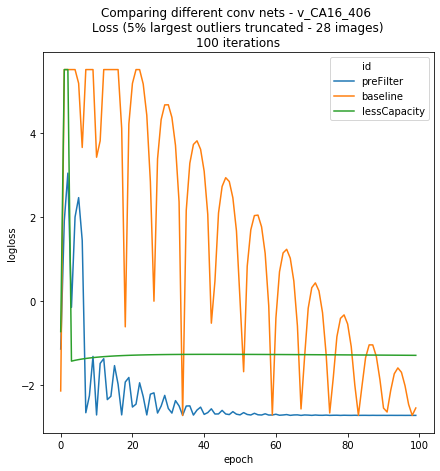

In [19]:
f=plt.figure(figsize=(7,7))
sns.lineplot(x='epoch',y='logloss',  hue='id',data=dfHistAll)
plt.title(f"Comparing different conv nets - {resp} \nLoss (5% largest outliers truncated - {numImgs} images)\n{numEpochs} iterations")
f.savefig( myPathBuilder.figuresOutputPath/ "PredictionsErrors" /'TestsMdlCompare' / f'convNet3ComparisonsModelLoss_{resp}_numImgs_{numImgs}_numEpochs_{numEpochs}.png' )

# Predictions

In [20]:
listMdls=[mdlFinal,convNetMdlCustom,convNetMdlCustomLessCapacity]
listHistNames=['preFilter','baseline','lessCapacity']
listDf=[]
for m,n in zip(listMdls,listHistNames):
    df=pd.DataFrame(m.predict(dictTrainTestValid['train']),columns=['pred'])
    df['obs'] = dictTrainTestValid['train'].yScaled
    df['id'] = n
    df['epoch'] = np.arange(df.shape[0])
    listDf.append(df)
    
dfPredAll=pd.concat(listDf)
dfPredAll.head()

pred       obs         id  epoch
0  0.416621  0.230827  preFilter      0
1  0.416621  0.752823  preFilter      1
2  0.416621  0.396202  preFilter      2
3  0.416621  0.244026  preFilter      3
4  0.416621  0.205601  preFilter      4

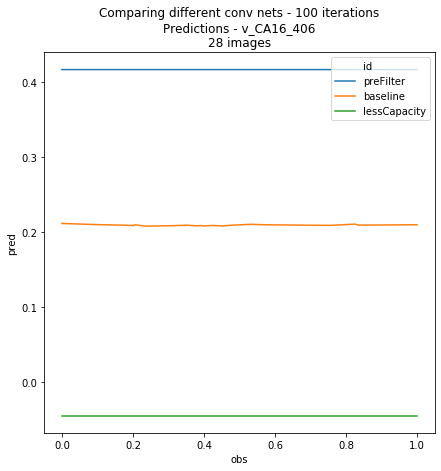

In [24]:
f=plt.figure(figsize=(7,7))
sns.lineplot(x='obs',y='pred', hue='id', data=dfPredAll)
plt.title(f"Comparing different conv nets - {numEpochs} iterations\nPredictions - {resp}\n{numImgs} images")
f.savefig( myPathBuilder.figuresOutputPath/ "PredictionsErrors" /'TestsMdlCompare' / f'convNet3ComparisonsPred_{resp}_numImgs_{numImgs}_numEpochs_{numEpochs}.png' )
